In [20]:


library(dplyr)
library(rio) #great for exporting, importing
library (stringr)
library(cowplot)
library(tidyr)
library(ggpubr)

library(readxl)
library(patchwork)
library(RColorBrewer)
library(viridis)
library(ggvenn)

# Import expression data with JTK analyses

In [2]:
#This data was generated using notebook ATL_AllelicGroupRhythmicity.ipynb
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

ExprGenes <- import(file = '../ATL_AllelicGroupRhythmicity/Results/ExpressedGenes_JTK_AllelicGroups.csv', 
                   sep =',', header = TRUE, fill = TRUE )

In [3]:
ExprGenes[1:2,]

,Syntelog,Tissue,Condition,ATL_expressed_alleles,geneID,target_id,Average,SD,CV,ATL_alleles,BH.Q,ADJ.P,Period,Adj_phase,Amplitude
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_1G000020.2,Soltu.Atl_v3.01_1G000020,7.395377,0.1577245,0.01760367,4,1,1,20,19,0.10051609
2,Synt_1,Leaf,LD,4,Soltu.Atl_v3.01_2G000020.1,Soltu.Atl_v3.01_2G000020,5.948141,0.1212230,0.02942801,4,1,1,20,4,0.09175902


# Import clock, tuberization, photoperiod control genes

In [4]:
    CG <- import(file = '../Tables/TableS1_CPT_ATL_DM.csv', 
                   sep =',', header = TRUE, fill = TRUE )

In [5]:
CG[1:2,]

,Group,Gene_Name,Functional_annotation,Genome,target_id,Representative_transcript,Gene,Gene_manual
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Tuberization,14-3-3,general regulatory factor,DM,Soltu.DM.04G030120,Soltu.DM.04G030120.1,Synt_11575,Synt_11575
2,Tuberization,14-3-3,general regulatory factor,ATL_H1,Soltu.Atl_v3.04_1G015000,Soltu.Atl_v3.04_1G015000.1,Synt_11575,Synt_11575


In [6]:
CG %>% select(Group) %>% unique()

,Group
,<chr>
1,Tuberization
79,Photoperiod
117,Clock
122,Clock_Aux
150,Clock_Photoperiod


In [7]:
## Number of CPT related transcripts in Atlantic
CG %>% filter(str_detect(Genome, 'ATL'))%>% nrow()
CG %>% select(Gene_Name) %>% unique() %>% nrow()

[1] 495

[1] 153

In [8]:
CG_ex <- ExprGenes %>% filter(target_id %in% CG$target_id) %>% left_join(CG %>% select(Group, Gene_Name, 
                                                                                         Genome, target_id,
                                                                                        Gene, Gene_manual), by = 'target_id')

## What is the percentage of rhythmic transcripts among CPT transcripts?

`summarise()` has grouped output by 'Condition'. You can override using the
`.groups` argument.
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


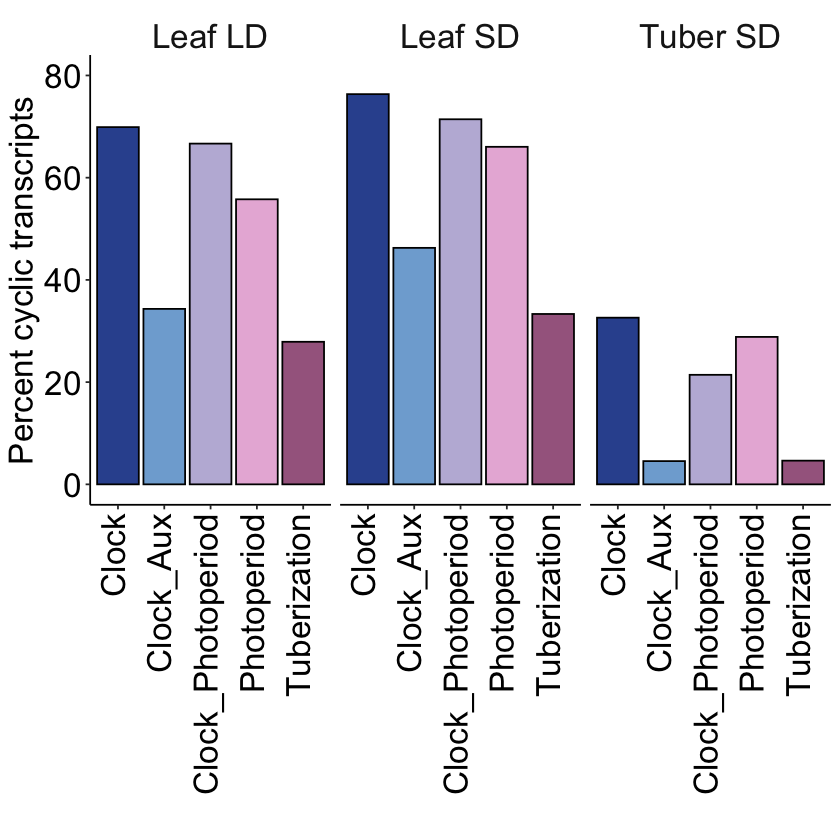

In [9]:
# Compare percent cycling of cycling allelic groups: CPT groups in Atlantic
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::;
Cond_labels <- c(LD = 'Leaf LD', SD= 'Leaf SD', Tuber ='Tuber SD')

PercentCyclingPlot <- CG_ex %>% select (Condition, Gene_Name, target_id, ADJ.P, Genome, Group, Tissue) %>%
            filter(str_detect(Genome, 'ATL'))%>% 
            mutate(Condition = case_when ((Condition == 'LD' & Tissue == 'Leaf') ~ 'LD',
                                          (Condition == 'SD' & Tissue == 'Leaf')~ 'SD',
                                          (Condition == 'SD' & Tissue == 'Tuber') ~ 'Tuber')) %>% 
            mutate(Condition = factor(Condition, levels = c('LD','SD', 'Tuber')))%>%
        select(-Tissue) %>%
            mutate( Group = as.factor(Group))%>%
            group_by (Condition, Group) %>% 
            summarize(PercentCycling = 100*sum(ADJ.P < 0.001)/n()) %>%
            
ggplot(aes(x= Group, y = PercentCycling ))+  #color= Group
            # geom_boxplot(trim=TRUE, aes(col = 'black', fill = Group))+  
             #geom_dotplot(binaxis='y', stackdir='center')+
            #geom_boxplot(aes(group = fullyCycling), width=0.1)+
            geom_col(color = 'black', aes( fill = Group))+
            labs(y="Percent cyclic transcripts", x="")+

          #  stat_summary(fun = median,
              # geom = "crossbar", 
             #  width = 0.1,
              # colour = "red")+  
          coord_cartesian(ylim=c(-0,80))+
   
scale_color_manual(values = c('Clock' = '#33539E', #light blue/grey                          
                                 'Clock_Aux'= '#7facd6', #darker blue/grey
                                   'Clock_Photoperiod'='#BFB8DA',#darker blue/grey #EE7733 orange
                                  'Photoperiod'='#E8B7DA',
                             'Tuberization'='#A5678E'))+ #0077BB blue

scale_fill_manual(values = alpha(c('Clock' = '#33539E', #light blue/grey                          

                                 'Clock_Aux'= '#7facd6', #darker blue/grey
                                   'Clock_Photoperiod'='#BFB8DA',#darker blue/grey #EE7733 orange
                                  'Photoperiod'='#E8B7DA',
                             'Tuberization'='#A5678E')))+ #0077BB blue

#scale_fill_brewer(palette = "Blues")+
theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
                axis.text.x=element_text(angle=90,hjust=1,vjust = 0.3),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
               #plot.title = element_text(size = 14)
        facet_grid(cols = vars(Condition),
                  labeller = labeller(Condition = Cond_labels))
       #stat_compare_means(label.y = 0.0013) + #Kruskal-Wallis multiple comparisons
       # stat_compare_means(comparisons = list(c('Clock','Clock_aux')), size = 6)# Adhoc pairwise comparisons p-value
      
#http://www.sthda.com/english/articles/24-ggpubr-publication-ready-plots/76-add-p-values-and-significance-levels-to-ggplots/

PercentCyclingPlot

In [10]:
PercentCyclingPlot %>% ggsave(file="./Results/CPT_PercentCycling_plot.pdf", width=8, height=7, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


In [11]:
## These are the percent expressed rhythmic transcripts genome wide in these conditions

df_transcr <- data.frame(yIntercept=c(19, 25.5, 1.1), ## These numbers come from notebook ATL_AllelicGroupRhythmicity
                  Condition = c('LD', 'SD', 'Tuber'))
df_transcr

yIntercept,Condition
<dbl>,<chr>
19.0,LD
25.5,SD
1.1,Tuber


`summarise()` has grouped output by 'Condition'. You can override using the
`.groups` argument.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


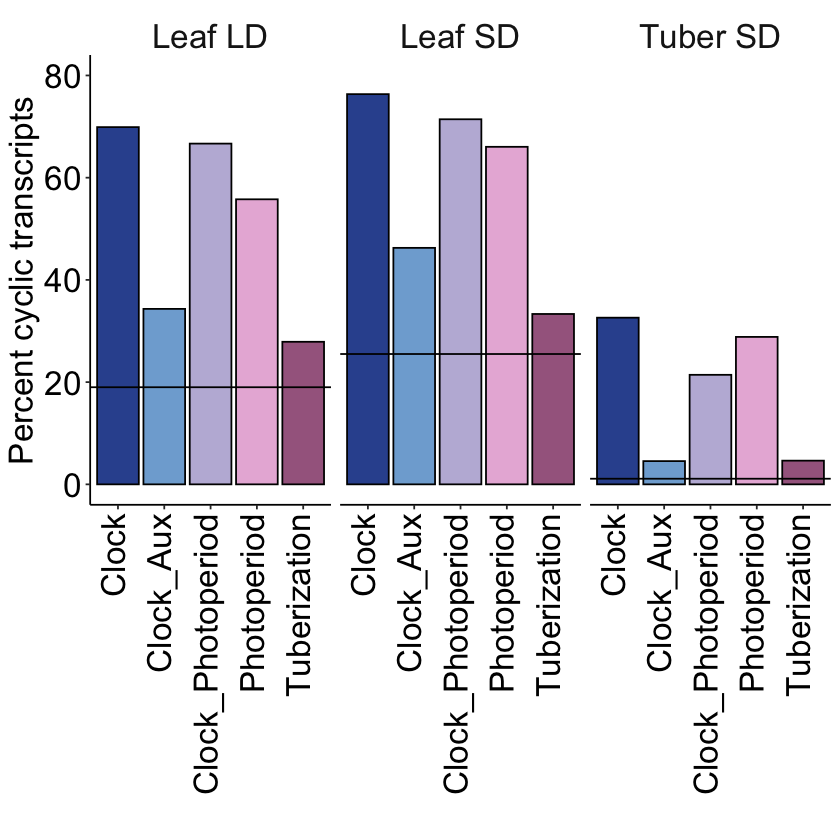

In [12]:
# Compare percent cycling of rhythmic: CPT groups in Atlantic - adding genome wide average
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::;
Cond_labels <- c(LD = 'Leaf LD', SD= 'Leaf SD', Tuber ='Tuber SD')

PercentCyclingPlot_Av <- CG_ex %>% select (Condition, Gene_Name, target_id, ADJ.P, Genome, Group, Tissue) %>%
            filter(str_detect(Genome, 'ATL'))%>% 
            mutate(Condition = case_when ((Condition == 'LD' & Tissue == 'Leaf') ~ 'LD',
                                          (Condition == 'SD' & Tissue == 'Leaf')~ 'SD',
                                          (Condition == 'SD' & Tissue == 'Tuber') ~ 'Tuber')) %>% 
            mutate(Condition = factor(Condition, levels = c('LD','SD', 'Tuber')))%>%
        select(-Tissue) %>%
            mutate( Group = as.factor(Group))%>%
            group_by (Condition, Group) %>% 
            summarize(PercentCycling = 100*sum(ADJ.P < 0.001)/n()) %>%
            
ggplot(aes(x= Group, y = PercentCycling ))+  #color= Group
      
            geom_col(color = 'black', aes( fill = Group))+
            labs(y="Percent cyclic transcripts", x="")+

      
          coord_cartesian(ylim=c(-0,80))+
   
scale_color_manual(values = c('Clock' = '#33539E', #light blue/grey                          
                                 'Clock_Aux'= '#7facd6', #darker blue/grey
                                   'Clock_Photoperiod'='#BFB8DA',#darker blue/grey #EE7733 orange
                                  'Photoperiod'='#E8B7DA',
                             'Tuberization'='#A5678E'))+ #0077BB blue

scale_fill_manual(values = alpha(c('Clock' = '#33539E', #light blue/grey                          

                                 'Clock_Aux'= '#7facd6', #darker blue/grey
                                   'Clock_Photoperiod'='#BFB8DA',#darker blue/grey #EE7733 orange
                                  'Photoperiod'='#E8B7DA',
                             'Tuberization'='#A5678E')))+ #0077BB blue

theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
                axis.text.x=element_text(angle=90,hjust=1,vjust = 0.3),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
               #plot.title = element_text(size = 14)


geom_hline(data= df_transcr, mapping = aes(yintercept = yIntercept), #linetype="dotted", 
                color = '#000000', size = 0.5)+

facet_grid(cols = vars(Condition),
                  labeller = labeller(Condition = Cond_labels))
       #stat_compare_means(label.y = 0.0013) + #Kruskal-Wallis multiple comparisons
       # stat_compare_means(comparisons = list(c('Clock','Clock_aux')), size = 6)# Adhoc pairwise comparisons p-value
      
#http://www.sthda.com/english/articles/24-ggpubr-publication-ready-plots/76-add-p-values-and-significance-levels-to-ggplots/

PercentCyclingPlot_Av

In [13]:
PercentCyclingPlot_Av %>% ggsave(file="./Results/CPT_PercentCycling_plot_Av.pdf", width=8, height=7, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


## What is the percentage fully rhythmic allelic groups among CPT genes?

Adding missing grouping variables: `Gene_Name`
`summarise()` has grouped output by 'Condition'. You can override using the
`.groups` argument.
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


LD         SD      Tuber 
 "Leaf LD"  "Leaf SD" "Tuber SD"

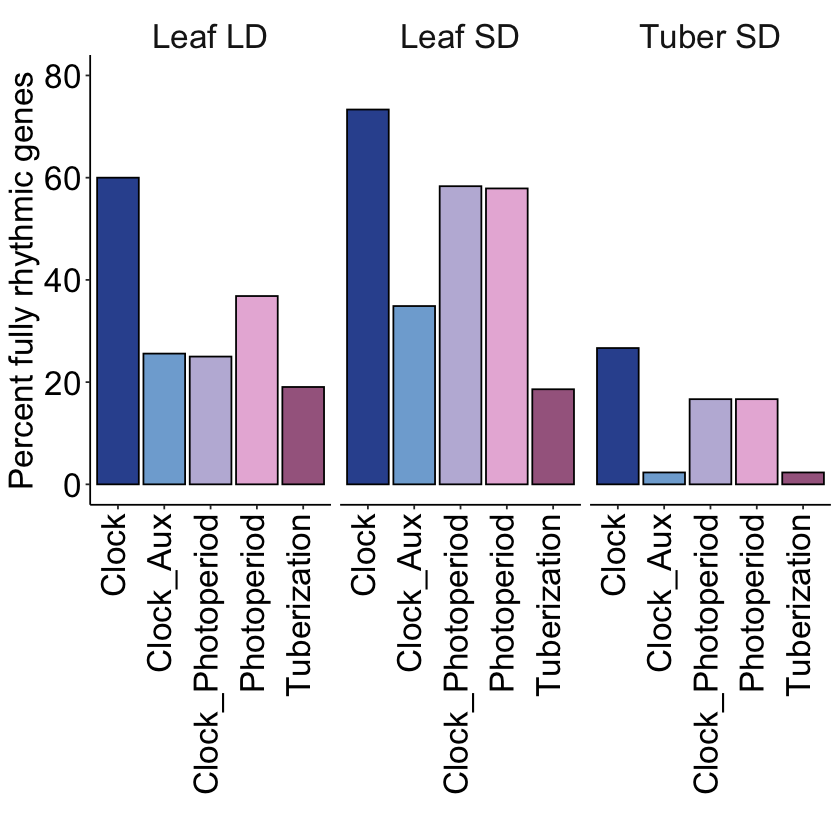

In [14]:
# Number of allelic groups that are fully cycling: CPT groups in Atlantic
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::;

Cond_labels <- c(LD = 'Leaf LD', SD = 'Leaf SD', Tuber ='Tuber SD')

PercentFullyCyclingSyn <- CG_ex %>% select (Condition, Gene_Name, target_id, ADJ.P, 
                                     Genome, Group, Tissue) %>%
            filter(str_detect(Genome, 'ATL'))%>% 
            mutate(Condition = case_when ((Condition == 'LD' & Tissue == 'Leaf') ~ 'LD',
                                          (Condition == 'SD' & Tissue == 'Leaf')~ 'SD',
                                          (Condition == 'SD' & Tissue == 'Tuber') ~ 'Tuber')) %>% 
            mutate(Condition = factor(Condition, levels = c('LD','SD', 'Tuber')))%>%
  
            select(-Tissue) %>% 
mutate(Condition = factor(Condition, levels = c('LD','SD', 'Tuber')))%>%  

        mutate(Group = as.factor(Group))%>%
            group_by (Gene_Name, Condition, Group) %>% 
            mutate(PercentCycling = 100*sum(ADJ.P < 0.001)/n())%>%
            select(Condition, Group, PercentCycling) %>% unique() %>%

            group_by(Condition, Group) %>%
            
    summarize (PercentFullCyclingSyn = sum(PercentCycling == 100)*100/n()) %>% 


            
ggplot(aes(x= Group, y = PercentFullCyclingSyn ))+  
           
            geom_col(color = 'black', aes(fill = Group))+
            labs(y="Percent fully rhythmic genes", x="")+

          coord_cartesian(ylim=c(-0,80))+
   
scale_color_manual(values = c('Clock' = '#33539E', #light blue/grey                          
                                 'Clock_Aux'= '#7facd6', #darker blue/grey
                                   'Clock_Photoperiod'='#BFB8DA',#darker blue/grey #EE7733 orange
                                  'Photoperiod'='#E8B7DA',
                             'Tuberization'='#A5678E'))+ #0077BB blue

scale_fill_manual(values = alpha(c('Clock' = '#33539E', #light blue/grey                          

                                 'Clock_Aux'= '#7facd6', #darker blue/grey
                                   'Clock_Photoperiod'='#BFB8DA',#darker blue/grey #EE7733 orange
                                  'Photoperiod'='#E8B7DA',
                             'Tuberization'='#A5678E')))+ #0077BB blue

#scale_fill_brewer(palette = "Blues")+

   theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
                axis.text.x=element_text(angle=90,hjust=1,vjust = 0.3),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
               #plot.title = element_text(size = 14)
      facet_grid(cols = vars(Condition),
                  labeller = labeller(Condition = Cond_labels))
       #stat_compare_means(label.y = 0.0013) + #Kruskal-Wallis multiple comparisons
       # stat_compare_means(comparisons = list(c('Clock','Clock_aux')), size = 6)# Adhoc pairwise comparisons p-value
      
#http://www.sthda.com/english/articles/24-ggpubr-publication-ready-plots/76-add-p-values-and-significance-levels-to-ggplots/

PercentFullyCyclingSyn
Cond_labels

In [15]:
PercentFullyCyclingSyn %>% ggsave(file="./Results/CPT_PercentFullyCyclingSyntelogs_plot.pdf", width=8, height=7, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


In [16]:
## These are the percent fully rhythmic allelic groups genome wide in these conditions

df_AllelicGroups <- data.frame(yIntercept=c(9.7, 14.5, 0.4), ## These numbers come from notebook ATL_AllelicGroupRhythmicity
                  Condition = c('LD', 'SD', 'Tuber'))
df_AllelicGroups

yIntercept,Condition
<dbl>,<chr>
9.7,LD
14.5,SD
0.4,Tuber


Adding missing grouping variables: `Gene_Name`
`summarise()` has grouped output by 'Condition'. You can override using the
`.groups` argument.
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


LD         SD      Tuber 
 "Leaf LD"  "Leaf SD" "Tuber SD"

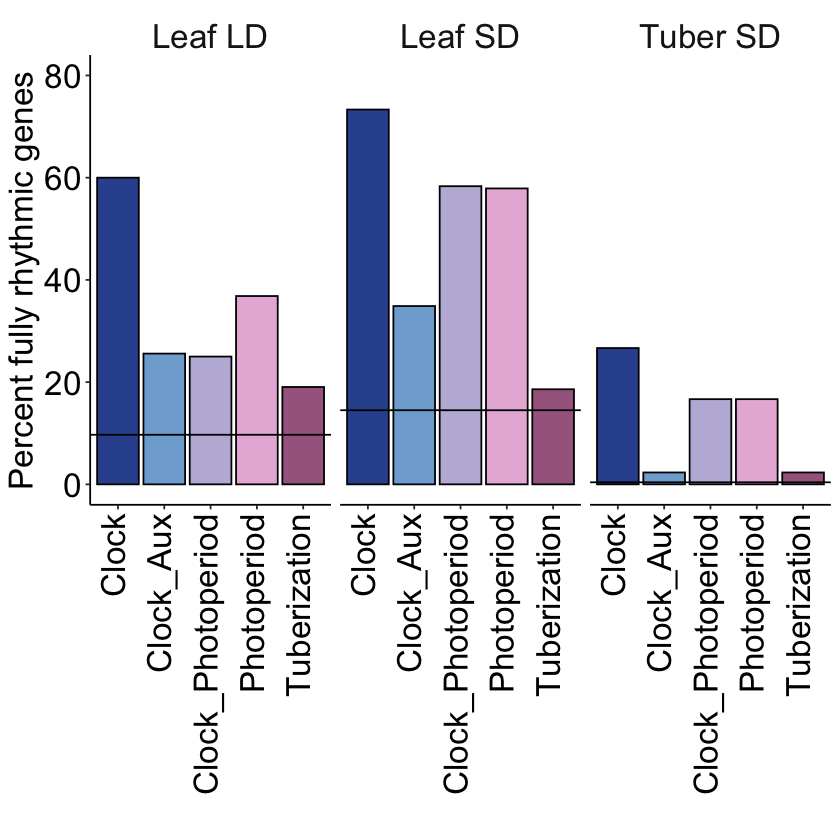

In [17]:
# Number of allelic groups that are fully cycling: CPT groups in Atlantic-Adding average genome wide
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::;

Cond_labels <- c(LD = 'Leaf LD', SD = 'Leaf SD', Tuber ='Tuber SD')

PercentFullyCyclingSyn_Av <- CG_ex %>% select (Condition, Gene_Name, target_id, ADJ.P, 
                                     Genome, Group, Tissue) %>%
            filter(str_detect(Genome, 'ATL'))%>% 
            mutate(Condition = case_when ((Condition == 'LD' & Tissue == 'Leaf') ~ 'LD',
                                          (Condition == 'SD' & Tissue == 'Leaf')~ 'SD',
                                          (Condition == 'SD' & Tissue == 'Tuber') ~ 'Tuber')) %>% 
            mutate(Condition = factor(Condition, levels = c('LD','SD', 'Tuber')))%>%
  
            select(-Tissue) %>% 
mutate(Condition = factor(Condition, levels = c('LD','SD', 'Tuber')))%>%  

        mutate(Group = as.factor(Group))%>%
            group_by (Gene_Name, Condition, Group) %>% 
            mutate(PercentCycling = 100*sum(ADJ.P < 0.001)/n())%>%
            select(Condition, Group, PercentCycling) %>% unique() %>%

            group_by(Condition, Group) %>%
            
    summarize (PercentFullCyclingSyn = sum(PercentCycling == 100)*100/n()) %>% 


            
ggplot(aes(x= Group, y = PercentFullCyclingSyn ))+  
           
            geom_col(color = 'black', aes(fill = Group))+
            labs(y="Percent fully rhythmic genes", x="")+

          coord_cartesian(ylim=c(-0,80))+
   
scale_color_manual(values = c('Clock' = '#33539E', #light blue/grey                          
                                 'Clock_Aux'= '#7facd6', #darker blue/grey
                                   'Clock_Photoperiod'='#BFB8DA',#darker blue/grey #EE7733 orange
                                  'Photoperiod'='#E8B7DA',
                             'Tuberization'='#A5678E'))+ #0077BB blue

scale_fill_manual(values = alpha(c('Clock' = '#33539E', #light blue/grey                          

                                 'Clock_Aux'= '#7facd6', #darker blue/grey
                                   'Clock_Photoperiod'='#BFB8DA',#darker blue/grey #EE7733 orange
                                  'Photoperiod'='#E8B7DA',
                             'Tuberization'='#A5678E')))+ #0077BB blue

geom_hline(data= df_AllelicGroups, mapping = aes(yintercept = yIntercept), #linetype="dotted", 
                color = '#000000', size = 0.5)+

   theme_classic()+
            theme (
            axis.title.x = element_text(size = 20),
            axis.title.y = element_text(size = 20),
            axis.text = element_text(size = 20, color = "black"),
                 strip.text.x = element_text(size = 20),
                axis.text.x=element_text(angle=90,hjust=1,vjust = 0.3),
            legend.position="none",
            strip.background = element_rect(color = "white"),
          strip.placement = "inside",
          strip.text = element_text(vjust = 0)) +
               #plot.title = element_text(size = 14)
      facet_grid(cols = vars(Condition),
                  labeller = labeller(Condition = Cond_labels))
       #stat_compare_means(label.y = 0.0013) + #Kruskal-Wallis multiple comparisons
       # stat_compare_means(comparisons = list(c('Clock','Clock_aux')), size = 6)# Adhoc pairwise comparisons p-value
      
#http://www.sthda.com/english/articles/24-ggpubr-publication-ready-plots/76-add-p-values-and-significance-levels-to-ggplots/

PercentFullyCyclingSyn_Av
Cond_labels

In [18]:
PercentFullyCyclingSyn_Av %>% ggsave(file="./Results/CPT_PercentFullyCyclingSyntelogs_plot_Av.pdf", width=8, height=7, dpi=600)

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


## Data table

In [19]:
CG_ex %>% select (Condition, Gene_Name, target_id, ADJ.P, 
                                     Genome, Group, Tissue) %>%
            filter(str_detect(Genome, 'ATL'))%>% 
            mutate(Condition = case_when ((Condition == 'LD' & Tissue == 'Leaf') ~ 'LD',
                                          (Condition == 'SD' & Tissue == 'Leaf')~ 'SD',
                                          (Condition == 'SD' & Tissue == 'Tuber') ~ 'Tuber')) %>% 
            mutate(Condition = factor(Condition, levels = c('LD','SD', 'Tuber')))%>%
  
            select(-Tissue) %>% 
mutate(Condition = factor(Condition, levels = c('LD','SD', 'Tuber')))%>%  

        mutate(Group = as.factor(Group))%>%
            group_by (Gene_Name, Condition, Group) %>% 
            mutate(PercentCycling = 100*sum(ADJ.P < 0.001)/n())%>%
            select(Condition, Group, PercentCycling) %>% unique() %>%

            group_by(Condition, Group) %>%
            
    summarize (PercentFullCyclingSyn = sum(PercentCycling == 100)*100/n())

Adding missing grouping variables: `Gene_Name`
`summarise()` has grouped output by 'Condition'. You can override using the
`.groups` argument.


Condition,Group,PercentFullCyclingSyn
<fct>,<fct>,<dbl>
LD,Clock,60.000000
LD,Clock_Aux,25.581395
LD,Clock_Photoperiod,25.000000
LD,Photoperiod,36.842105
LD,Tuberization,19.047619
SD,Clock,73.333333
SD,Clock_Aux,34.883721
SD,Clock_Photoperiod,58.333333
SD,Photoperiod,57.894737
